# Udacity Self-Driving Car
## Vehicle Detection Project

## 0 Library Import

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle
from skimage.feature import hog
import time

%matplotlib inline

We will define a ```read_rgb_img``` function to make sure images' pixel value are in sacle of [0, 256].

In [2]:
def read_rgb_img(img_path):
    if img_path.endswith('.jpg'):
        return mpimg.imread(img_path)
    elif img_path.endswith('.png'):
        img = cv2.imread(img_path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        raise Exception("Image format does not support: {}".format(img_path)) 

## 1 Dataset Exploration

We will explore datasets for training a **binary car classifier**. The data we have are in ```vehicles``` and ```non-vehicles``` folders.

Text(0.5,1,'sample non car image')

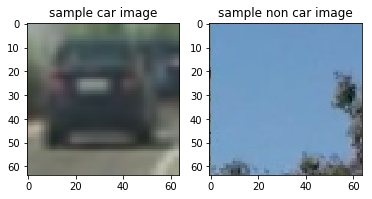

In [3]:
root_vehicles_dir = 'vehicles'
root_non_vehicles_dir = 'non-vehicles'

vehicles_files = glob.glob(root_vehicles_dir + '/*/*.png')
non_vehicles_files = glob.glob(root_non_vehicles_dir + '/*/*.png')


example_vehicle_img = read_rgb_img(vehicles_files[0])
example_non_vehicle_img = read_rgb_img(non_vehicles_files[0])

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(example_vehicle_img)
ax1.set_title('sample car image')

ax2.imshow(example_non_vehicle_img)
ax2.set_title('sample non car image')


## 2 Image features


### Color Histogram

In [4]:
def color_hist(img, nbins = 32, bins_range = (0, 256), visualise = False):
    ch1_hist = np.histogram(img[:,:,0], nbins, bins_range)
    ch2_hist = np.histogram(img[:,:,1], nbins, bins_range)
    ch3_hist = np.histogram(img[:,:,2], nbins, bins_range)
    
    bin_centers = (ch1_hist[1][0:-1] + ch1_hist[1][1:])
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    
    if visualise:
        return ch1_hist, ch2_hist, ch3_hist, bin_centers, hist_features
    else:
        return hist_features
    
    

Test on example image.

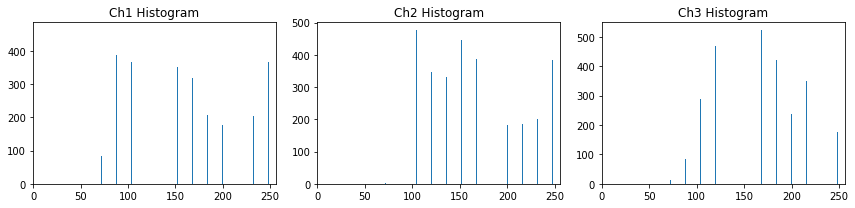

In [5]:
ch1, ch2, ch3, bincen, hist_features = color_hist(example_vehicle_img, visualise = True)

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bincen, ch1[0])
plt.xlim(0, 256)
plt.title('Ch1 Histogram')
plt.subplot(132)
plt.bar(bincen, ch2[0])
plt.xlim(0, 256)
plt.title('Ch2 Histogram')
plt.subplot(133)
plt.bar(bincen, ch3[0])
plt.xlim(0, 256)
plt.title('Ch3 Histogram')
fig.tight_layout()

### Spatial Binning of Color



In [6]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

Text(0.5,1,'Spatially Binned Features')

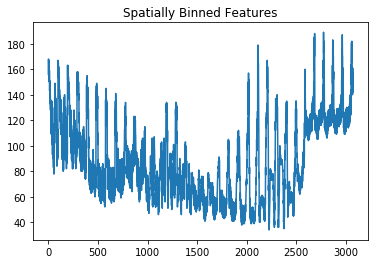

In [7]:
feature_vec = bin_spatial(example_vehicle_img, size=(32, 32))
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

### Gradient Feature: Hog


In [8]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(
                            img, 
                            orientations=orient,
                            pixels_per_cell=(pix_per_cell, pix_per_cell), 
                            cells_per_block=(cell_per_block, cell_per_block), 
                            visualise=True, 
                            feature_vector=feature_vec,
                            transform_sqrt = False)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(
                img, 
                orientations=orient,
                pixels_per_cell=(pix_per_cell, pix_per_cell), 
                cells_per_block=(cell_per_block, cell_per_block), 
                visualise=False, 
                feature_vector=feature_vec,
                transform_sqrt = False)
        return features

/Users/xianlei/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Text(0.5,1,'HOG Visualization')

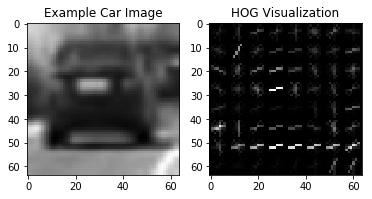

In [9]:
gray = cv2.cvtColor(example_vehicle_img, cv2.COLOR_RGB2GRAY)


# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, 
                                       orient = 9, 
                                       pix_per_cell = 8, 
                                       cell_per_block = 2, 
                                       vis=True)

fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


### Combine and Normalize Image features


In [10]:
def extract_features(imgs, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    for img_file in imgs:
        img = read_rgb_img(img_file)
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        
        bin_feature = bin_spatial(feature_image, spatial_size)
        color_feature = color_hist(feature_image, hist_bins, hist_range)
        
        hog1 = get_hog_features(feature_image[:,:,0], 
                                orient = 9, 
                                pix_per_cell = 8, 
                                cell_per_block = 2,
                                vis=False)
        hog2 = get_hog_features(feature_image[:,:,1], 
                                orient = 9, 
                                pix_per_cell = 8, 
                                cell_per_block = 2,
                                vis=False)
        hog3 = get_hog_features(feature_image[:,:,2], 
                                orient = 9, 
                                pix_per_cell = 8, 
                                cell_per_block = 2,
                                vis=False)
        
        hog_feature = np.concatenate((hog1, hog2, hog3))
        features.append(np.concatenate((bin_feature, color_feature, hog_feature)))
    return features


In [11]:
def normalize_features(X):                      
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    return X_scaler

/Users/xianlei/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Feature size: 8460


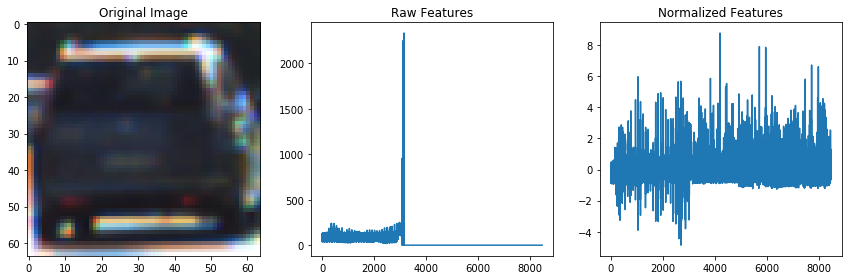

In [12]:
car_features = extract_features(vehicles_files)
notcar_features = extract_features(non_vehicles_files)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = normalize_features(X)
scaled_X = X_scaler.transform(X)
print('Feature size: {}'.format(X.shape[1]))

car_ind = np.random.randint(0, len(car_features))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(read_rgb_img(vehicles_files[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## 3 Training Classifier

### Shuffling training and test data

In [13]:
normalized_car_features = X_scaler.transform(np.array(car_features))
normalized_notcar_features = X_scaler.transform(np.array(notcar_features))

y_car = np.ones(len(normalized_car_features))
y_notcar = np.zeros(len(normalized_notcar_features))

X_car_train, X_car_test, y_car_train, y_car_test = train_test_split(normalized_car_features, y_car, test_size=0.33, shuffle=True)
X_notcar_train, X_notcar_test, y_notcar_train, y_notcar_test = train_test_split(normalized_notcar_features, y_notcar, test_size=0.33, shuffle=True)

X_train = np.vstack((X_car_train, X_notcar_train))
y_train = np.concatenate((y_car_train, y_notcar_train))

X_test = np.vstack((X_car_test, X_notcar_test))
y_test = np.concatenate((y_car_test, y_notcar_test))

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)


print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('cars: {}, non cars: {}'.format(
    X_car_train.shape[0], 
    X_notcar_train.shape[0]))


print('X_test shape: {}, y_test shape: {}'.format(X_test.shape, y_test.shape))
print('cars: {}, non cars: {}'.format(
    X_car_test.shape[0], 
    X_notcar_test.shape[0]))



X_train shape: (11898, 8460), y_train shape: (11898,)
cars: 5890, non cars: 6008
X_test shape: (5862, 8460), y_test shape: (5862,)
cars: 2902, non cars: 2960


### Training Model with SVM

In [14]:
parameters = {'kernel': ('linear',), 'C':[1, 10]}
svc = SVC()
svm_clf = GridSearchCV(svc, parameters)

t=time.time()
svm_clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

728.44 Seconds to train SVC...


In [15]:
print('Training Accuracy of SVC = ', round(svm_clf.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svm_clf.score(X_test, y_test), 4))

Training Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9928


Test on example Image

/Users/xianlei/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


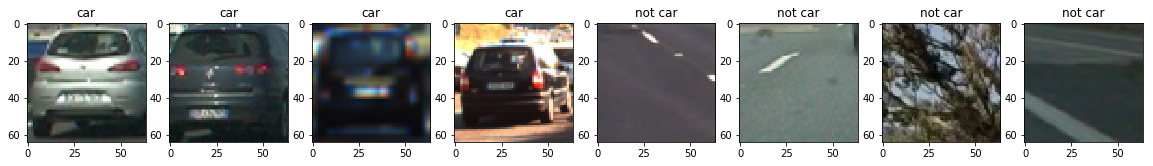

In [16]:
test_images = shuffle(vehicles_files)[0:4] + shuffle(non_vehicles_files)[0:4]
test_features = extract_features(test_images)

normalized_test_features = X_scaler.transform(test_features)
test_prediction = svm_clf.predict(normalized_test_features)

plt.figure(figsize = (20, 20))
for i, test_image in enumerate(test_images):
    plt.subplot(1,8, i+1)
    plt.imshow(read_rgb_img(test_image))
    
    prediction = 'car' if test_prediction[i] == 1 else 'not car'
    plt.title(prediction)

## Hog Sub-sampling Window Search

In [17]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, 
              svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, 
              spatial_size, 
              hist_bins):
    
    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction:
                draw = False
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(
                    (
                        (xbox_left, ytop_draw+ystart),
                        (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                    )
                )
    return draw_img, bboxes

Test on video images

/Users/xianlei/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


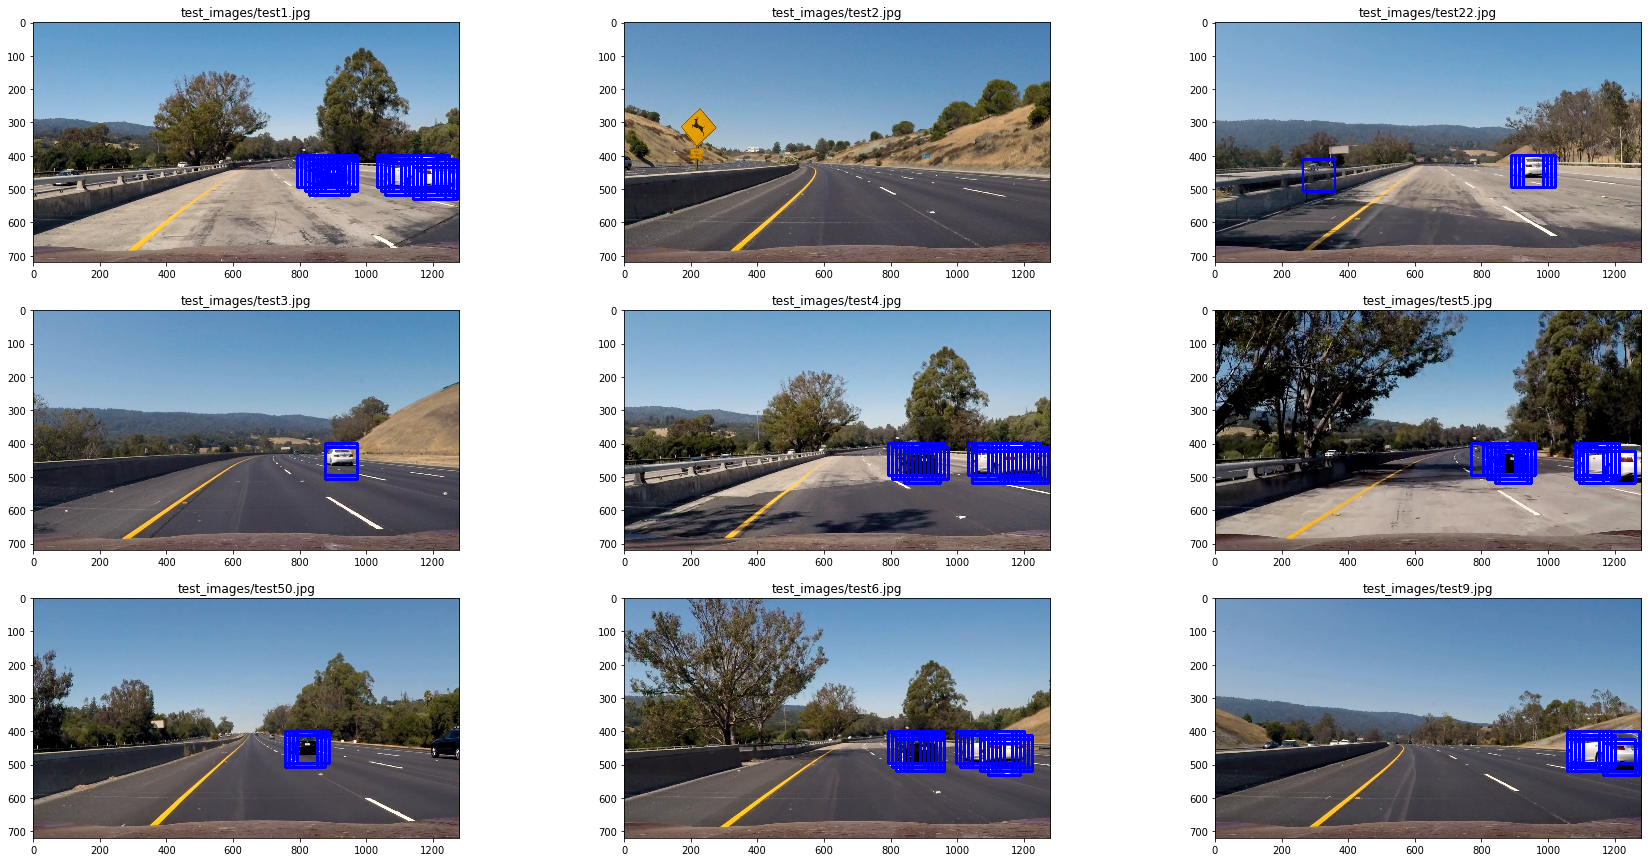

In [18]:
test_video_imgs = glob.glob('test_images/*.jpg')
detect_imgs = []
bboxes_from_img = []

plt.figure(figsize=(30,15))
for i, test_video_img_file in enumerate(test_video_imgs):
    test_video_img = read_rgb_img(test_video_img_file)
    detect_img, bboxes = find_cars(test_video_img, 
                           ystart = 400, ystop = 656, scale = 1.5,
                           svc = svm_clf, X_scaler = X_scaler,
                           orient = 9, pix_per_cell = 8, cell_per_block = 2,
                           spatial_size = (32, 32),
                           hist_bins = 32
                          )

    detect_imgs.append(detect_img)
    bboxes_from_img.append(bboxes)
    
    plt.subplot(3,3,i+1)
    plt.imshow(detect_img)
    plt.title(test_video_img_file)

## Multiple Detections & False Positives


In [19]:
def get_heatmap(img, bbox_list):    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)

    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

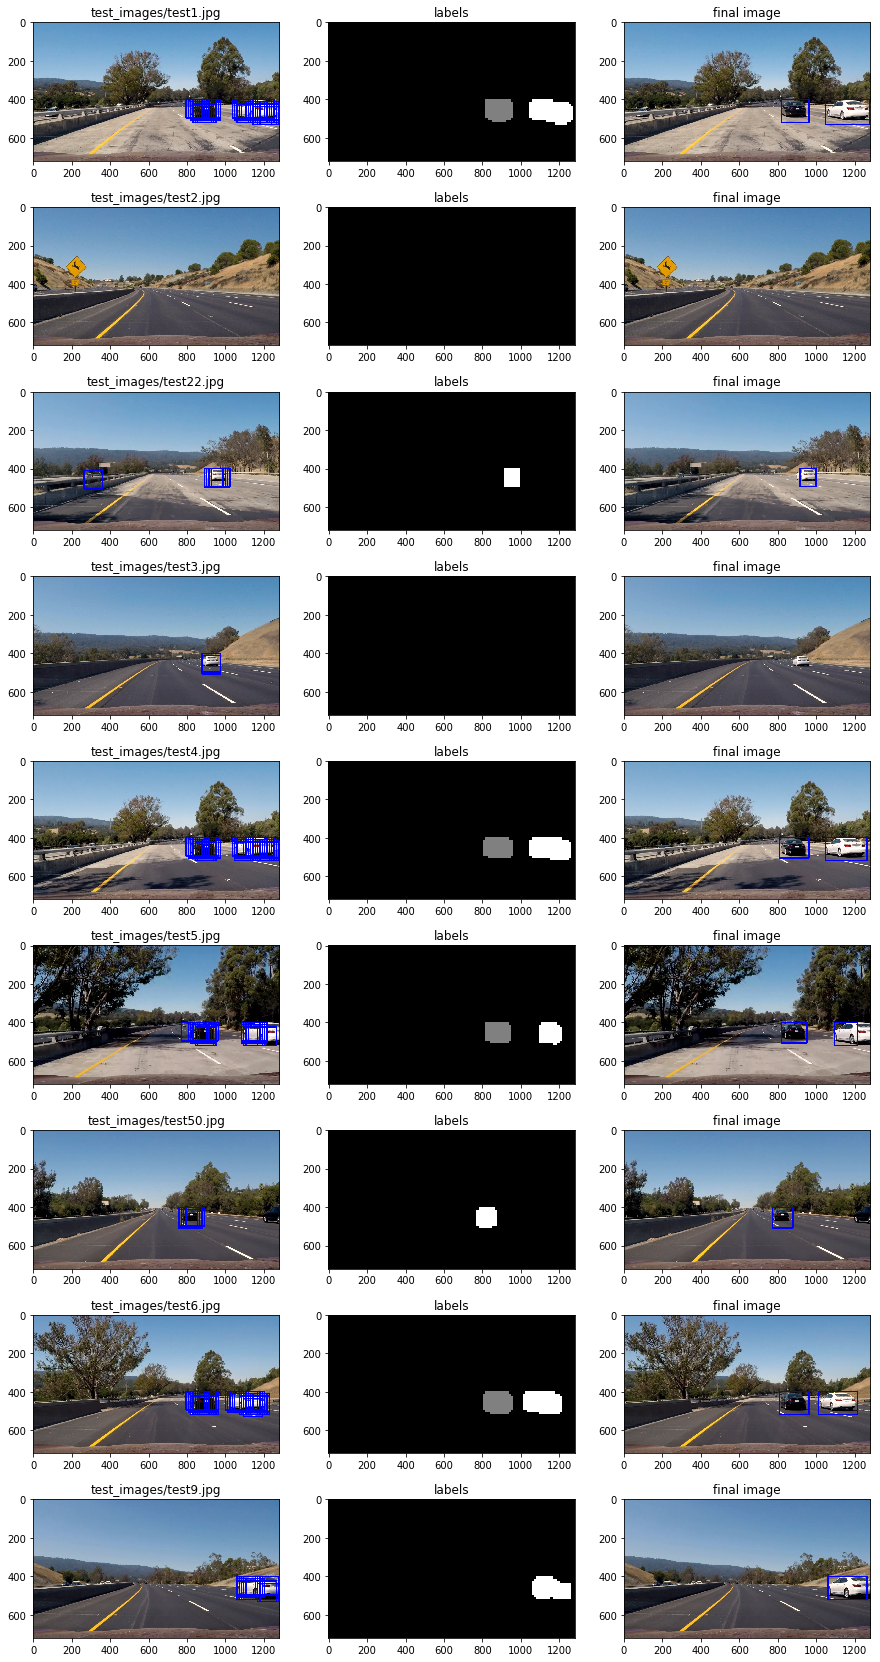

In [20]:
plt.figure(figsize=(15,30))
num_images = len(test_video_imgs)
for i, test_video_img_file in enumerate(test_video_imgs):
    test_video_img = read_rgb_img(test_video_img_file)
    heatmap = get_heatmap(test_video_img, bboxes_from_img[i])
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    
    plt.subplot(num_images,3,3*i+1)
    plt.imshow(detect_imgs[i])
    plt.title(test_video_img_file)
    
    plt.subplot(num_images,3,3*i+2)
    plt.imshow(labels[0], cmap='gray')
    plt.title('labels')
    
    plt.subplot(num_images,3,3*i+3)
    plt.imshow(draw_labeled_bboxes(test_video_img, labels))
    plt.title('final image')



## Process Images


In [21]:
def detect_cars_for_video_frame(video_img):
    
    detect_img, bboxes = find_cars(video_img, 
                           ystart = 400, ystop = 656, scale = 1.5,
                           svc = svm_clf, X_scaler = X_scaler,
                           orient = 9, pix_per_cell = 8, cell_per_block = 2,
                           spatial_size = (32, 32),
                           hist_bins = 32
                          )
    
    heatmap = get_heatmap(video_img, bboxes)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    result_img = draw_labeled_bboxes(video_img, labels)
    
    return result_img

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

input_video = 'project_video.mp4'
output_video = 'output_video/' + input_video
clip1 = VideoFileClip(input_video)

Sample Image Frame with errors

In [ ]:
def save_error_frame(t):
    error_frame = clip1.get_frame(t)
    mpimg.imsave('test_images/test' + str(t) + '.jpg', error_frame, format = 'jpg')

save_error_frame(9)
save_error_frame(22)
save_error_frame(50)

Process Video

In [ ]:
white_clip = clip1.fl_image(detect_cars_for_video_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


 37%|███▋      | 463/1261 [1:19:33<2:15:56, 10.22s/it]

In [125]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))